# SWB Connectivity Results: Beta Coherence

Created: 08/28/2024 \
Updated: 09/02/2024 \
*using new all_behav data from swb_subj_behav class*


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter


import mne_connectivity
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
# import fooof
# Import plotting functions
# from fooof.plts.spectra import plot_spectrum, plot_spectra
# # Import the FOOOF object
# from fooof import FOOOF
# from fooof import FOOOFGroup

from tqdm import tqdm
from IPython.display import clear_output

from joblib import delayed, Parallel
from statsmodels.stats import multitest
import warnings
warnings.filterwarnings('ignore')
# print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

%load_ext autoreload
%autoreload 2



In [2]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
neural_dir = f'{base_dir}ephys_analysis/data/'
save_dir   = f'{base_dir}ephys_analysis/results/beta_coherence/'
os.makedirs(save_dir,exist_ok=True)

script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'
behav_dir  = f'{script_dir}behav/data/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)

# anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
# behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'


09022024


In [3]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils,oscillation_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *

sys.path.append(f'{script_dir}behav/')

from behav_utils import *
from swb_subj_behav import *


In [4]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load Behav + Elec ROI Data
- all behav from coherence analysis scripts 
- roi_reref_labels same as usual

In [5]:
# all_behav = pd.read_csv(f'{behav_dir}all_behav.csv') ## this isn't normalized yet 
# raw_behav = [pd.read_csv(f'{behav_dir}{subj_id}_task_df.csv') for subj_id in subj_ids]
# all_behav,drops_data = format_all_behav(raw_behav,drops_data=True)

all_behav =  pd.read_csv(f'{save_dir}all_behav_clean_08282024.csv')


In [6]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0]).drop(columns=['Unnamed: 0'])

# roi_reref_labels_master_df #= roi_reref_labels_master_df



In [ ]:
# #### update all subjects epochs data and resave 
# epoch_id = 'CpeOnset'
# # iterate through subjects
# for subj_id in subj_ids:
#     print(subj_id)
#     # load & format rereferenced epoch data 
#     subj_epochs = mne.read_epochs(f'{neural_dir}{subj_id}/{epoch_id}_epochs.fif', preload=True)
#     # drop bad trials
#     subj_drops = drops_data[subj_id]
#     subj_epochs.drop(subj_drops)
#     # replace old metadata with updated subject data
#     subj_epochs.metadata = all_behav[all_behav.subj_id == subj_id]
#     # save updated epochs data
#     subj_epochs.save(f'{neural_dir}{subj_id}/{epoch_id}_epochs-clean.fif', overwrite=True)
#     del subj_epochs

# Connectivity Computations : Beta Coherence 

In [8]:
# define connectivity analysis parameters:

# spectral parameters - wavelet freqs, wavelet cycles, freq band ranges
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

freq_dict = {'theta':[4, 9], 
            'alpha':[9, 13],
            'beta': [13, 30], 
            'hfa': [70, 200]}

# analysis parameters - connectivity metric, conn freq band, num of surrogates for permutations, buffer time in ms
metric   = 'coh'
band     = 'beta' # set band(s) of interest for analysis
n_surr   = 500
buf_ms   = 1000

# data info - analysis epoch + rois for pairwise coh
epoch_id = 'CpeOnset' 
# rois
coh_rois = ['acc','ains','ofc','dlpfc','vlpfc','amy']
# coh_rois = ['ofc','dlpfc','vlpfc','amy']
# dict of subj_ids with elecs in roi 
roi_subj_ids = {f'{roi}':roi_reref_labels_master_df.subj_id[
    roi_reref_labels_master_df.roi == roi].unique().tolist() 
                for roi in coh_rois}
# make unique list of pairs [[pair1,pair2],..] without hard coding 
pairs = [list(tup) for tup in list(itertools.combinations(coh_rois,2))]
# complete_pairs = pairs[:-4]
# complete_pairs
pairs

[['acc', 'ains'],
 ['acc', 'ofc'],
 ['acc', 'dlpfc'],
 ['acc', 'vlpfc'],
 ['acc', 'amy'],
 ['ains', 'ofc'],
 ['ains', 'dlpfc'],
 ['ains', 'vlpfc'],
 ['ains', 'amy'],
 ['ofc', 'dlpfc'],
 ['ofc', 'vlpfc'],
 ['ofc', 'amy'],
 ['dlpfc', 'vlpfc'],
 ['dlpfc', 'amy'],
 ['vlpfc', 'amy']]

In [9]:
# load coh data 

all_pairs_coh_data = []
all_pair_subj = {}

for pair in pairs:
    
    source_region = pair[0]
    target_region = pair[1]    
    
    # unique pair id roi1_roi2
    pair_id = '_'.join([source_region,target_region])
    
    # find subj with elecs in each roi 
    source_subj = roi_subj_ids[source_region]
    target_subj = roi_subj_ids[target_region]
    # find subj with elecs in both rois
    pair_subj = list(set(source_subj).intersection(target_subj))    
    # save pair subj list 
    all_pair_subj[pair_id] = pair_subj
    
    pair_data = pd.read_csv(f'{save_dir}{pair_id}_{metric}_{band}_df.csv')
#     pair_data = pair_data.drop(columns='index')
    pair_data['epoch'] = pair_data['index'].copy()
    pair_data['Round'] = pair_data['epoch']+1

    for subj_id in pair_data.subj_id.unique().tolist():
        subj_behav   = all_behav[all_behav.subj_id == subj_id]
        subj_pair_df = pair_data[pair_data.subj_id == subj_id]
        subj_pair_df['coh_z'] = zscore(subj_pair_df.coh)
        subj_pair_df['coh_norm'] = norm_zscore(subj_pair_df.coh)
        
        # merge pair df with subj_behav 
        subj_pair_df = pd.merge(subj_pair_df, subj_behav,left_on=
                                      ['subj_id','bdi','epoch','Round'],right_on=
                                      ['subj_id','bdi','epoch','Round']).reset_index(
                                        drop=True)
        subj_pair_df['cpe_split'] = subj_pair_df['cpe'].apply(lambda x: 0 if x < np.nanmean(subj_pair_df.cpe) else 1)
        # add all_subj_pair_df to master df 
        all_pairs_coh_data.append(subj_pair_df)
    


    


In [10]:
all_pairs_coh_data = pd.concat(all_pairs_coh_data).reset_index(drop=True)

In [11]:
all_pairs_coh_data

,index,epoch,coh,unique_ch_pair,roi_pair_chans,roi1_ch_names,roi2_ch_names,roi1_elec_idx,roi2_elec_idx,subj_id,...,res_type_t1,cf_t1,max_cf_t1,cpe_t1,max_cpe_t1,keep_epoch,keep_epoch_t1,CpeOnset,cpe_split,Unnamed: 0
0,0,0,0.614884,MS003_lacas2-lacas3_laimm1-laimm2,lacas2-lacas3_laimm1-laimm2,lacas2-lacas3,laimm1-laimm2,[ 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 ...,[14 15 16 17 56 57 58 59 14 15 16 17 56 57 58 ...,MS003,...,gamble_good,0.020585,-0.147868,0.030970,0.129651,keep,keep,678.379679,0,NaN
1,0,0,0.607001,MS003_lacas2-lacas3_laimm2-laimm3,lacas2-lacas3_laimm2-laimm3,lacas2-lacas3,laimm2-laimm3,[ 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 ...,[14 15 16 17 56 57 58 59 14 15 16 17 56 57 58 ...,MS003,...,gamble_good,0.020585,-0.147868,0.030970,0.129651,keep,keep,678.379679,0,NaN
2,0,0,1.512935,MS003_lacas2-lacas3_laimm3-laimm4,lacas2-lacas3_laimm3-laimm4,lacas2-lacas3,laimm3-laimm4,[ 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 ...,[14 15 16 17 56 57 58 59 14 15 16 17 56 57 58 ...,MS003,...,gamble_good,0.020585,-0.147868,0.030970,0.129651,keep,keep,678.379679,0,NaN
3,0,0,2.741457,MS003_lacas2-lacas3_laimm4-laimm5,lacas2-lacas3_laimm4-laimm5,lacas2-lacas3,laimm4-laimm5,[ 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 ...,[14 15 16 17 56 57 58 59 14 15 16 17 56 57 58 ...,MS003,...,gamble_good,0.020585,-0.147868,0.030970,0.129651,keep,keep,678.379679,0,NaN
4,0,0,-1.109453,MS003_lacas2-lacas3_raimm1-raimm2,lacas2-lacas3_raimm1-raimm2,lacas2-lacas3,raimm1-raimm2,[ 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 ...,[14 15 16 17 56 57 58 59 14 15 16 17 56 57 58 ...,MS003,...,gamble_good,0.020585,-0.147868,0.030970,0.129651,keep,keep,678.379679,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401685,146,146,2.760797,MS048_rains5-rains6_laglt2-laglt3,rains5-rains6_laglt2-laglt3,rains5-rains6,laglt2-laglt3,[80 80 80 80 80 80],[ 7 8 9 10 73 74],MS048,...,safe_good,-0.504855,-0.402032,0.461214,0.322714,keep,keep,1938.511339,1,NaN
1401686,146,146,-0.671882,MS048_rains5-rains6_laglt3-laglt4,rains5-rains6_laglt3-laglt4,rains5-rains6,laglt3-laglt4,[80 80 80 80 80 80],[ 7 8 9 10 73 74],MS048,...,safe_good,-0.504855,-0.402032,0.461214,0.322714,keep,keep,1938.511339,1,NaN
1401687,146,146,-0.855067,MS048_rains5-rains6_laglt4-laglt5,rains5-rains6_laglt4-laglt5,rains5-rains6,laglt4-laglt5,[80 80 80 80 80 80],[ 7 8 9 10 73 74],MS048,...,safe_good,-0.504855,-0.402032,0.461214,0.322714,keep,keep,1938.511339,1,NaN
1401688,146,146,-1.202495,MS048_rains5-rains6_raglt1-raglt2,rains5-rains6_raglt1-raglt2,rains5-rains6,raglt1-raglt2,[80 80 80 80 80 80],[ 7 8 9 10 73 74],MS048,...,safe_good,-0.504855,-0.402032,0.461214,0.322714,keep,keep,1938.511339,1,NaN


In [13]:
save_dir

'/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/beta_coherence/'

In [14]:
all_pairs_coh_data.to_csv(f'{save_dir}all_pairs_coh_data_{date}.csv')

In [15]:
all_pairs_coh_data.columns

Index(['index', 'epoch', 'coh', 'unique_ch_pair', 'roi_pair_chans',
       'roi1_ch_names', 'roi2_ch_names', 'roi1_elec_idx', 'roi2_elec_idx',
       'subj_id', 'bdi', 'Round', 'band', 'metric', 'pair_id', 'roi1', 'roi2',
       'coh_z', 'coh_norm', 'bdi_thresh', 'RT', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'ChoicePos', 'TrialType', 'SafeBet',
       'LowBet', 'HighBet', 'GambleChoice', 'Outcome', 'Profit', 'TotalProfit',
       'logRT', 'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'res_type',
       'cf', 'max_cf', 'cpe', 'max_cpe', 'Round_t1', 'RT_t1', 'ChoicePos_t1',
       'TrialType_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'GambleChoice_t1', 'Outcome_t1', 'Profit_t1', 'TotalProfit_t1',
       'epoch_t1', 'logRT_t1', 'GambleEV_t1', 'TrialEV_t1', 'CR_t1',
       'choiceEV_t1', 'rpe_t1', 'res_type_t1', 'cf_t1', 'max_cf_t1', 'cpe_t1',
       'max_cpe_t1', 'keep_epoch', 'keep_epoch_t1', 'CpeOnset', 'cpe_split',
       'Unnamed: 0'],
      d

In [16]:
# all data points all electrodes corr

beta_coh_bdi_df = []


for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    pair_coeff, pair_pval = [pair_rlm.params[-1],pair_rlm.pvalues[-1]]
    # robust regression w bdi 
    low_cpe_df  = pair_df[pair_df.cpe_split==0]
    high_cpe_df = pair_df[pair_df.cpe_split==1]
    
    lowcpe_pair_rlm = sm.RLM(low_cpe_df.bdi.values, sm.add_constant(low_cpe_df.coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    low_cpe_coeff, low_cpe_pval = [lowcpe_pair_rlm.params[-1],lowcpe_pair_rlm.pvalues[-1]]
    #     print('pair id :', f'{pair_id} coeff = {lowcpe_pair_rlm.params[-1]} pval = {lowcpe_pair_rlm.pvalues[-1]}')
    
    highcpe_pair_rlm = sm.RLM(high_cpe_df.bdi.values, sm.add_constant(high_cpe_df.coh.values), 
                              M=sm.robust.norms.HuberT()).fit()
    high_cpe_coeff, high_cpe_pval = [highcpe_pair_rlm.params[-1],highcpe_pair_rlm.pvalues[-1]]
#     print('pair id :', f'{pair_id} coeff = {highcpe_pair_rlm.params[-1]} pval = {highcpe_pair_rlm.pvalues[-1]}')
    beta_coh_bdi_df.append(pd.DataFrame({'pair_id':pair_id,
                                         'pair_coeff':pair_coeff,
                                         'pair_pval':np.round(pair_pval,6),
                                         'low_cpe_coeff':low_cpe_coeff,
                                         'low_cpe_pval':np.round(low_cpe_pval,6),
                                         'high_cpe_coeff':high_cpe_coeff,
                                         'high_cpe_pval':np.round(high_cpe_pval,6)},index=[0]))
    
beta_coh_bdi_df = pd.concat(beta_coh_bdi_df).reset_index(drop=True)
beta_coh_bdi_df


,pair_id,pair_coeff,pair_pval,low_cpe_coeff,low_cpe_pval,high_cpe_coeff,high_cpe_pval
0,acc_ains,-3.854031e-01,0.000000,-3.376557e-01,0.000000,-4.269233e-01,0.000000
1,acc_ofc,-8.174026e-02,0.000000,-8.122229e-02,0.000002,-8.221651e-02,0.000001
2,acc_dlpfc,-6.355726e-02,0.000028,-2.230158e-02,0.300683,-1.038531e-01,0.000001
3,acc_vlpfc,-1.688225e-01,0.000000,-1.279361e-01,0.000000,-2.101069e-01,0.000000
4,acc_amy,8.961024e-02,0.000000,9.919709e-02,0.000029,8.000017e-02,0.000635
5,ains_ofc,2.085465e-02,0.223949,7.162228e-02,0.005633,-2.632141e-02,0.252805
6,ains_dlpfc,2.785977e-01,0.000000,3.018695e-01,0.000000,2.541768e-01,0.000000
7,ains_vlpfc,-1.969696e-01,0.000000,-1.389317e-01,0.000000,-2.335650e-01,0.000000
8,ains_amy,9.527220e-02,0.000440,1.170218e-01,0.005538,7.078230e-02,0.053627
9,ofc_dlpfc,3.116737e-01,0.000000,3.196381e-01,0.000000,3.044675e-01,0.000000


In [18]:
# roi pair mean correlation
# 

beta_coh_bdi_df = []


for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    
    total_pair_df = pair_df.copy().groupby(['subj_id','unique_ch_pair']).agg('mean')

    pair_rlm = sm.RLM(total_pair_df.bdi.values, sm.add_constant(total_pair_df.coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    pair_coeff, pair_pval = [pair_rlm.params[-1],pair_rlm.pvalues[-1]]
    # robust regression w bdi 
    cpe_df = pair_df.copy().groupby(['subj_id','cpe_split']).agg('mean').reset_index()
#     low_cpe_df  = pair_df[pair_df.cpe_split==0]
#     high_cpe_df = pair_df[pair_df.cpe_split==1]
    
    lowcpe_pair_rlm = sm.RLM(cpe_df[cpe_df.cpe_split==0].bdi, sm.add_constant(cpe_df[cpe_df.cpe_split==0].coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    low_cpe_coeff, low_cpe_pval = [lowcpe_pair_rlm.params[-1],lowcpe_pair_rlm.pvalues[-1]]
    #     print('pair id :', f'{pair_id} coeff = {lowcpe_pair_rlm.params[-1]} pval = {lowcpe_pair_rlm.pvalues[-1]}')
    
    highcpe_pair_rlm = sm.RLM(cpe_df[cpe_df.cpe_split==1].bdi.values, sm.add_constant(cpe_df[cpe_df.cpe_split==1].coh.values), 
                              M=sm.robust.norms.HuberT()).fit()
    high_cpe_coeff, high_cpe_pval = [highcpe_pair_rlm.params[-1],highcpe_pair_rlm.pvalues[-1]]
#     print('pair id :', f'{pair_id} coeff = {highcpe_pair_rlm.params[-1]} pval = {highcpe_pair_rlm.pvalues[-1]}')
    beta_coh_bdi_df.append(pd.DataFrame({'pair_id':pair_id,
                                         'pair_coeff':pair_coeff,
                                         'pair_pval':np.round(pair_pval,6)*10,
                                         'low_cpe_coeff':low_cpe_coeff,
                                         'low_cpe_pval':np.round(low_cpe_pval,6)*10,
                                         'high_cpe_coeff':high_cpe_coeff,
                                         'high_cpe_pval':np.round(high_cpe_pval,6)*10},index=[0]))
    
beta_coh_bdi_df = pd.concat(beta_coh_bdi_df).reset_index(drop=True)
beta_coh_bdi_df

,pair_id,pair_coeff,pair_pval,low_cpe_coeff,low_cpe_pval,high_cpe_coeff,high_cpe_pval
0,acc_ains,-6.127158e+00,0.00000,-31.033580,0.08263,-21.545267,0.36981
1,acc_ofc,-1.265917e+00,0.22759,-7.273716,5.92502,-11.984359,3.27183
2,acc_dlpfc,-6.858367e-01,2.36426,0.960819,8.87132,-2.241200,7.54029
3,acc_vlpfc,-4.927437e+00,0.00000,-14.739654,3.51847,-12.159023,2.75655
4,acc_amy,4.991344e+00,0.00419,22.078312,2.96938,6.268380,7.94352
5,ains_ofc,2.320448e-01,6.20900,-2.483701,7.13838,-3.889300,5.31205
6,ains_dlpfc,6.072279e+00,0.00000,7.183283,5.01891,7.235152,4.85899
7,ains_vlpfc,-3.748173e-01,2.02741,1.217805,5.27040,0.948655,5.90973
8,ains_amy,4.196425e+00,0.23840,10.366147,1.33915,11.145576,0.94678
9,ofc_dlpfc,3.192179e+00,0.00000,0.863803,8.84353,2.435216,6.76138


In [ ]:
# nodes of interest: acc, ains, dlpfc, maybe amy,vlpfc,ofc

In [19]:
# roi pair mean correlation
# 

beta_coh_bdi_df = []


for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    
    total_pair_df = pair_df.copy().groupby(['subj_id']).agg('mean')

    pair_rlm = sm.RLM(total_pair_df.bdi.values, sm.add_constant(total_pair_df.coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    pair_coeff, pair_pval = [pair_rlm.params[-1],pair_rlm.pvalues[-1]]
    # robust regression w bdi 
    cpe_df = pair_df.copy().groupby(['subj_id','cpe_split']).agg('mean').reset_index()
#     low_cpe_df  = pair_df[pair_df.cpe_split==0]
#     high_cpe_df = pair_df[pair_df.cpe_split==1]
    
    lowcpe_pair_rlm = sm.RLM(cpe_df[cpe_df.cpe_split==0].bdi, sm.add_constant(cpe_df[cpe_df.cpe_split==0].coh.values),
                      M=sm.robust.norms.HuberT()).fit()
    low_cpe_coeff, low_cpe_pval = [lowcpe_pair_rlm.params[-1],lowcpe_pair_rlm.pvalues[-1]]
    #     print('pair id :', f'{pair_id} coeff = {lowcpe_pair_rlm.params[-1]} pval = {lowcpe_pair_rlm.pvalues[-1]}')
    
    highcpe_pair_rlm = sm.RLM(cpe_df[cpe_df.cpe_split==1].bdi.values, sm.add_constant(cpe_df[cpe_df.cpe_split==1].coh.values), 
                              M=sm.robust.norms.HuberT()).fit()
    high_cpe_coeff, high_cpe_pval = [highcpe_pair_rlm.params[-1],highcpe_pair_rlm.pvalues[-1]]
#     print('pair id :', f'{pair_id} coeff = {highcpe_pair_rlm.params[-1]} pval = {highcpe_pair_rlm.pvalues[-1]}')
    beta_coh_bdi_df.append(pd.DataFrame({'pair_id':pair_id,
                                         'pair_coeff':pair_coeff,
                                         'pair_pval':np.round(pair_pval,6),
                                         'low_cpe_coeff':low_cpe_coeff,
                                         'low_cpe_pval':np.round(low_cpe_pval,6),
                                         'high_cpe_coeff':high_cpe_coeff,
                                         'high_cpe_pval':np.round(high_cpe_pval,6)},index=[0]))
    
beta_coh_bdi_df = pd.concat(beta_coh_bdi_df).reset_index(drop=True)
beta_coh_bdi_df

,pair_id,pair_coeff,pair_pval,low_cpe_coeff,low_cpe_pval,high_cpe_coeff,high_cpe_pval
0,acc_ains,-26.377470,0.021380,-31.033580,0.008263,-21.545267,0.036981
1,acc_ofc,-9.997167,0.444013,-7.273716,0.592502,-11.984359,0.327183
2,acc_dlpfc,-0.497420,0.944173,0.960819,0.887132,-2.241200,0.754029
3,acc_vlpfc,-14.468674,0.294822,-14.739654,0.351847,-12.159023,0.275655
4,acc_amy,16.767708,0.480918,22.078312,0.296938,6.268380,0.794352
5,ains_ofc,-3.294682,0.614130,-2.483701,0.713838,-3.889300,0.531205
6,ains_dlpfc,7.230348,0.496757,7.183283,0.501891,7.235152,0.485899
7,ains_vlpfc,1.074892,0.538175,1.217805,0.527040,0.948655,0.590973
8,ains_amy,10.867596,0.111986,10.366147,0.133915,11.145576,0.094678
9,ofc_dlpfc,1.555902,0.793843,0.863803,0.884353,2.435216,0.676138


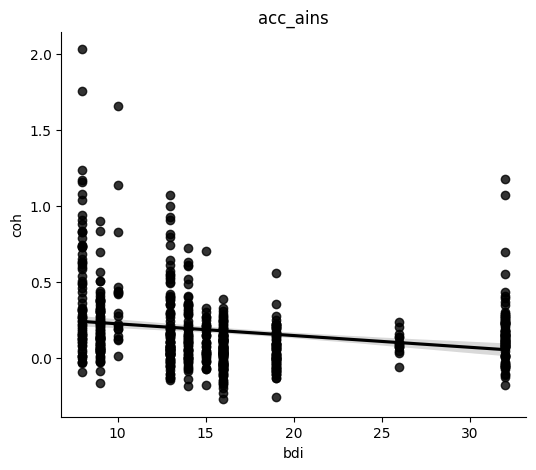

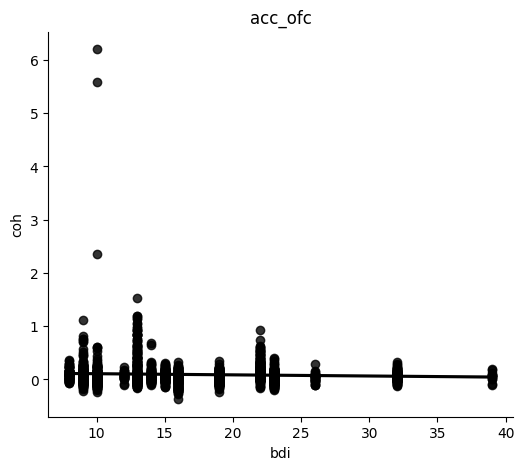

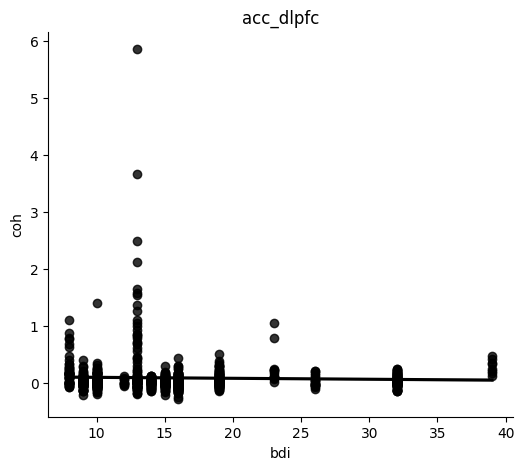

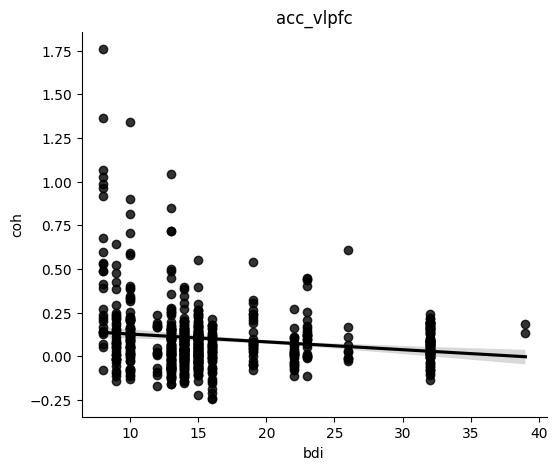

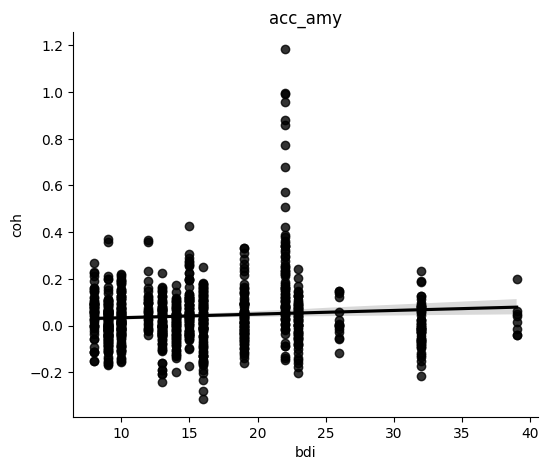

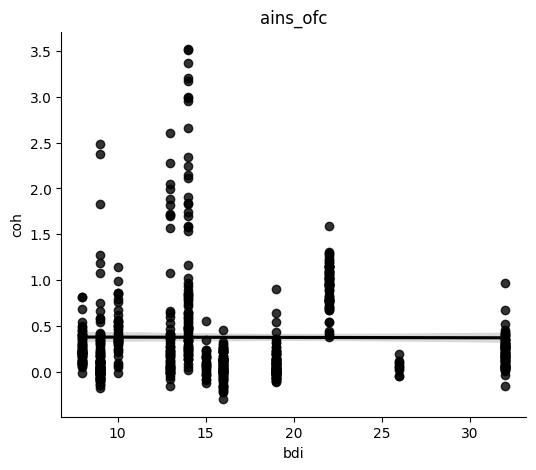

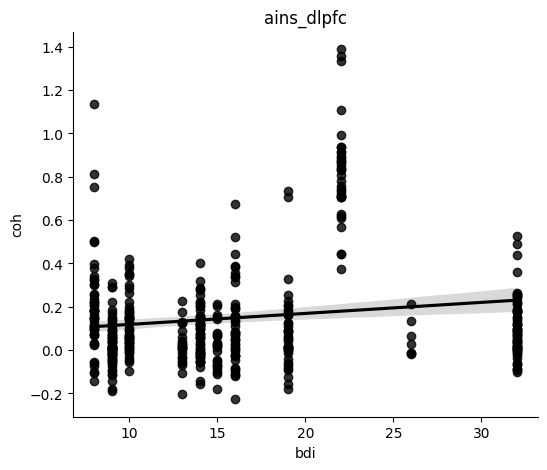

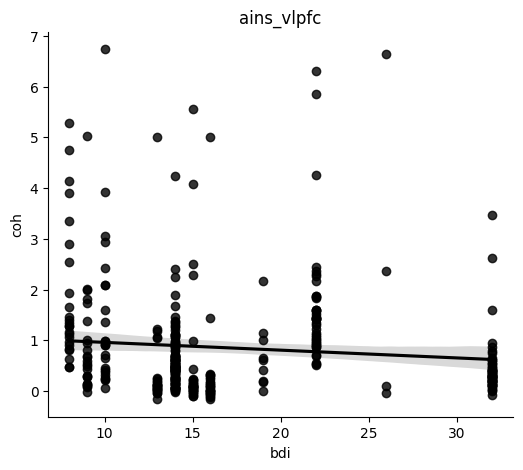

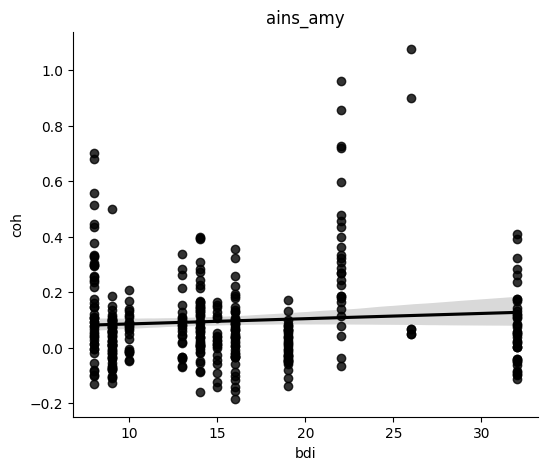

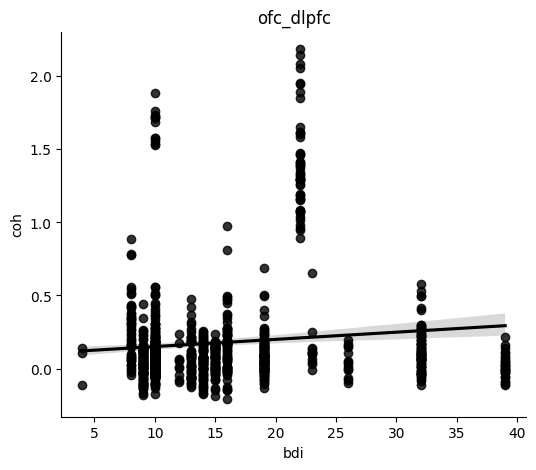

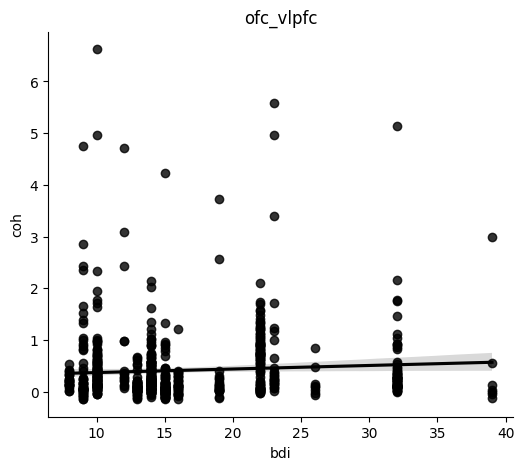

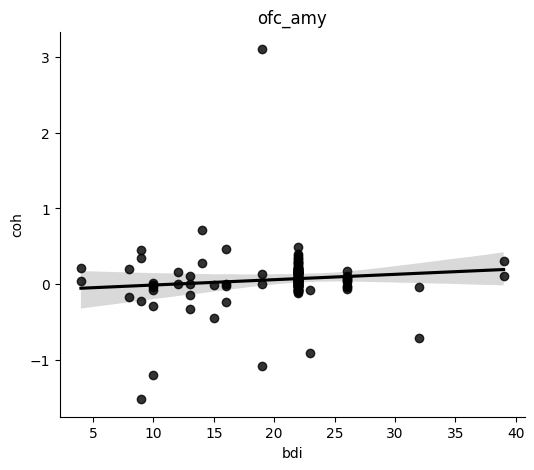

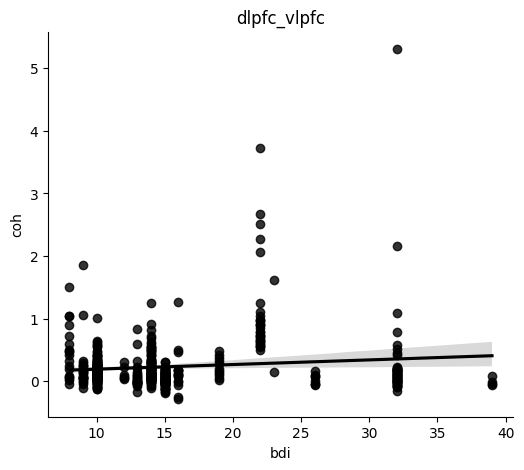

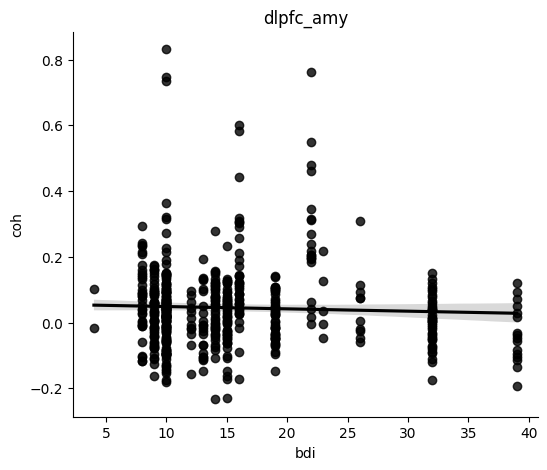

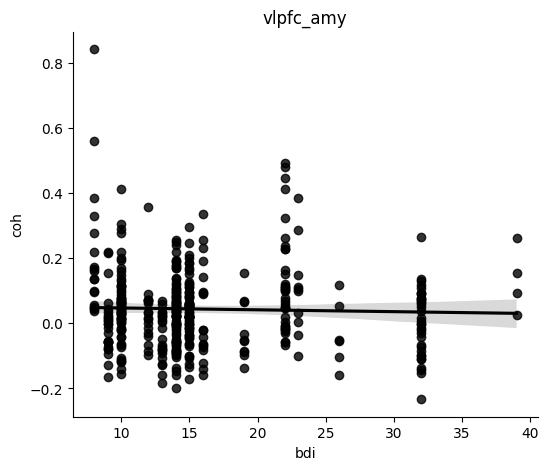

In [20]:
# # add behav data to df 
# pair_df_dict  = {}
# pair_rlm_dict = {}

for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
#     total_pair_df = pair_df.copy().groupby(['subj_id']).agg('mean')
    # robust regression w bdi 
#     pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values), M=sm.robust.norms.HuberT()).fit()
#     print('pair id :', f'{pair_id} coeff = {pair_rlm.params[-1]} pval = {pair_rlm.pvalues[-1]}')
#     # save data 
#     pair_rlm_dict[pair_id] = pair_rlm
#     pair_df_dict[pair_id]  = pair_df
    
    # plot subj elec means by bdi
    pair_bdi_df = pair_df.groupby(['subj_id','unique_ch_pair']).agg('mean').reset_index()
    
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    sns.regplot(data=pair_bdi_df,x='bdi',y='coh',scatter=True,ci=95,color='k')
    plt.title(pair_id)
    sns.despine()

    

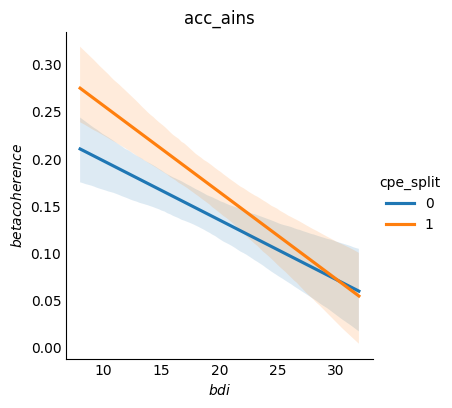

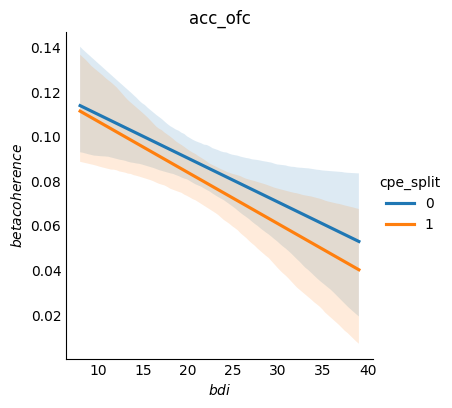

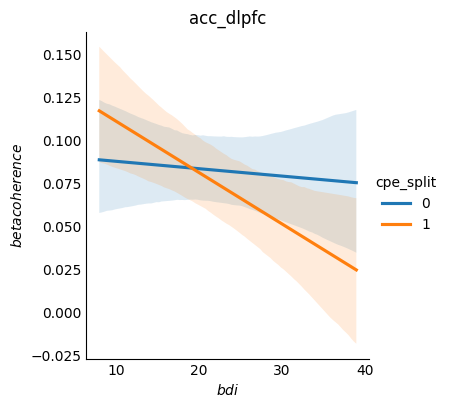

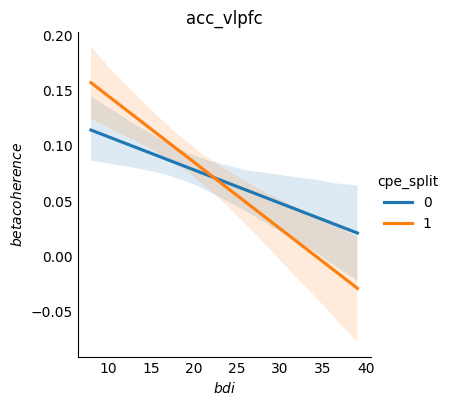

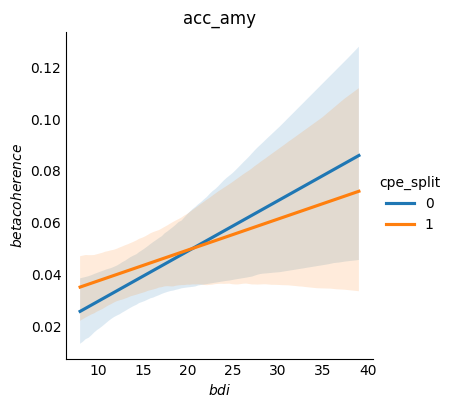

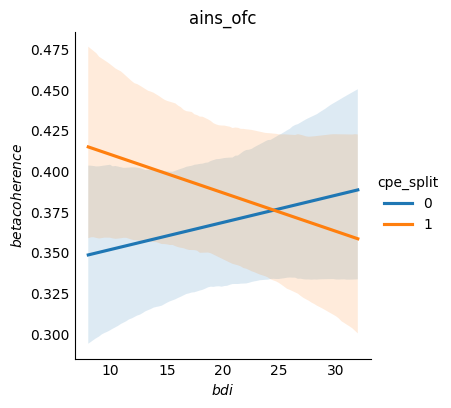

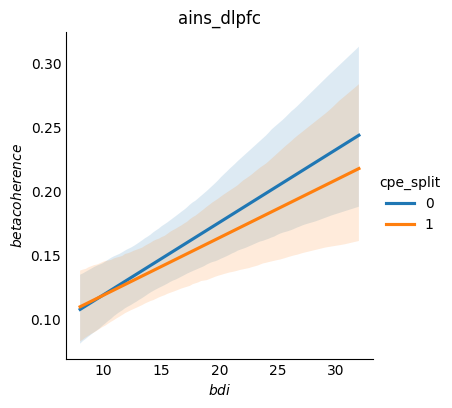

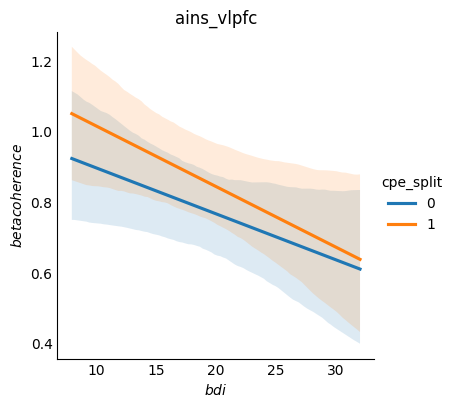

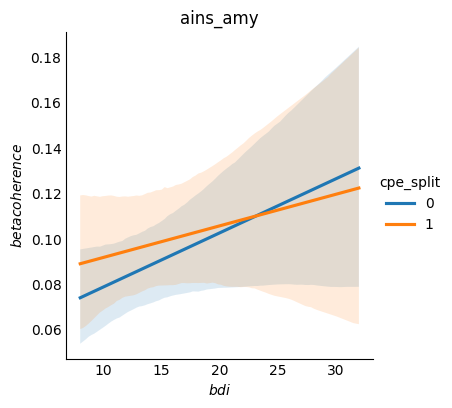

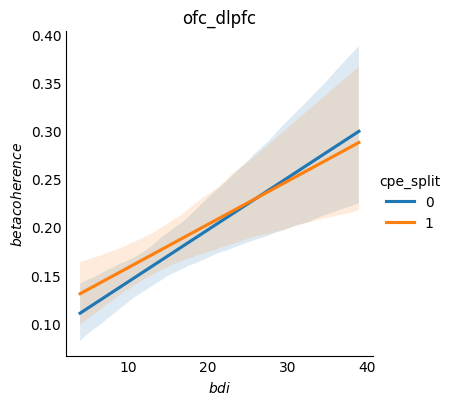

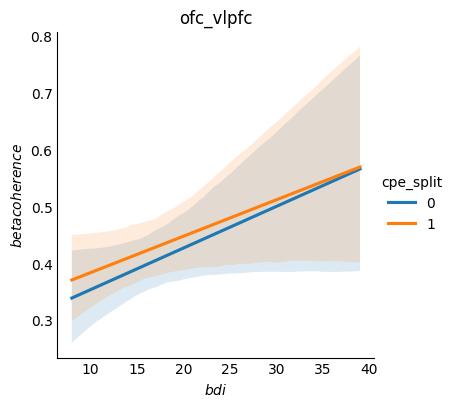

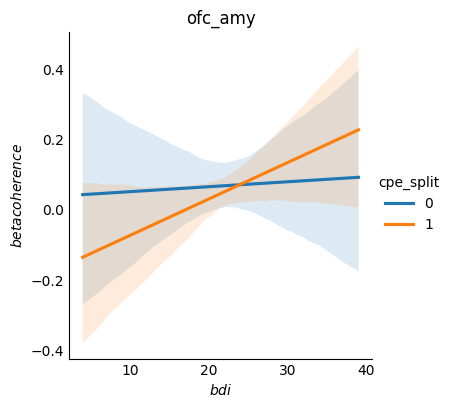

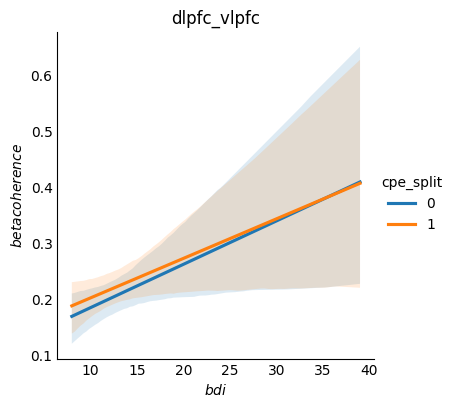

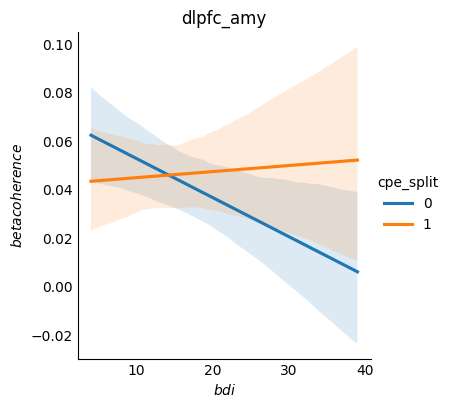

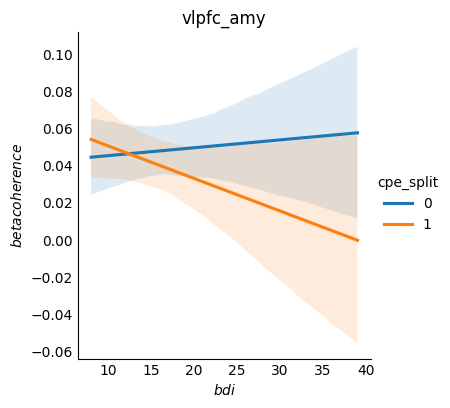

In [21]:
# add behav data to df 
pair_df_dict  = {}
pair_rlm_dict = {}

for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    
    
#     # robust regression w bdi 
#     pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values), M=sm.robust.norms.HuberT()).fit()
#     print('pair id :', f'{pair_id} coeff = {pair_rlm.params[-1]} pval = {pair_rlm.pvalues[-1]}')
#     # save data 
#     pair_rlm_dict[pair_id] = pair_rlm
#     pair_df_dict[pair_id]  = pair_df

#      low_cpe_df  = pair_df[pair_df.cpe_split==0]
#     high_cpe_df = pair_df[pair_df.cpe_split==1]
    
    # plot subj elec means by bdi
    pair_bdi_df = pair_df.groupby(['subj_id','unique_ch_pair','cpe_split']).agg('mean').reset_index()
    
#     fig,ax = plt.subplots(1,1,figsize=(7,5))
#     sns.regplot(data=pair_bdi_df,x='bdi',y='coh',scatter=True,ci=95,color='k',color='cpe_split')
    ax = sns.lmplot(data=pair_bdi_df,x='bdi',y='coh',hue='cpe_split',scatter=False,height=4, 
           aspect=1,ci=95)
#     sns.move_legend(ax,"upper center", bbox_to_anchor=(0.5, 1), borderaxespad=0.1,frameon=False,framealpha=0,
#                 fontsize='x-small',shadow=None,title=None,columnspacing=0.5,edgecolor=None,markerfirst=True,
#                 markerscale=4,labelcolor=None, ncol=2)
    plt.ylabel(r'$beta coherence$')
    plt.xlabel(r'$bdi$')
    plt.tick_params(length=0)
    plt.title(pair_id)
    sns.despine()

    

# Potential models
- keep BDI as dependent variable

1. **BDI ~ 1 + CPE + Coh + CPE:Coh (elec level rand slopes/intercepts and subj level intercepts)**
2. Coh ~ CPE then BDI ~ B(coh ~ CPE)
3. Coh ~ 1+CPE + BDI + CPE:BDI (subj or elec level rand effects) for every roi pair separately

In [22]:
### normalize coherence metric 
norm_coh = []
for ch in all_pairs_coh_data.unique_ch_pair.unique().tolist():
    ch_df = all_pairs_coh_data[all_pairs_coh_data.unique_ch_pair == ch]
    ch_df['norm_coh'] = norm_zscore(ch_df['coh'])
    norm_coh.extend(ch_df['norm_coh'])

In [24]:
all_pairs_coh_data['norm_coh'] = norm_coh

In [25]:
roi_pair = 'ains_ofc'
model_data = all_pairs_coh_data[all_pairs_coh_data.pair_id == roi_pair]
model_data['Groups'] = 1
model_data = model_data.reset_index(drop=True)


In [28]:

def fit_multi_mixed_model(df, regressor_vars, rand_slope_vars,
                          outcome_var, rand_eff_var, rand_int_var, reml=True):
    
    # define formula, random effects formula
    formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
    re_formula = f'1+ {(" + ").join(rand_slope_vars)}'
#     vc_formula = {f'var':f'0 + {rand_int_var}' for var in rand_slope_vars}
    vc_formula = {f'C({rand_eff_var})':f'{re_formula} + C({rand_eff_var})',
                  f'C({rand_int_var})':f'1 + C({rand_int_var})'}

    return smf.mixedlm(formula = formula, re_formula = re_formula,vc_formula = vc_formula,
        data = df, groups=df['Groups'], missing='drop').fit(reml=reml)

# def fit_multi_mixed_model(df, regressor_vars, rand_slope_vars,
#                           outcome_var, rand_eff_var, rand_int_var, reml=True):
    
#     # define formula, random effects formula
#     formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
#     re_formula = f'1+ {(" + ").join(rand_slope_vars)}'
#     vc_formula = {f'{rand_eff_var}':f'{re_formula} + C({rand_eff_var})',
#                   f'{rand_int_var}':f'1 + C({rand_int_var})'}
# #                  ,
                
#     # fit model
#     return smf.mixedlm(formula = formula, re_formula = re_formula,vc_formula = vc_formula,
#         data = df, groups=np.ones(df.shape[0]), missing='drop').fit(reml=reml)



# mixed_lm_model = smf.mixedlm(model_formula, dframe, groups=dframe['class'], 
#                              re_formula='1', vc_formula={'class:student_id': '0 + C(student_id)'})


# re_formula="1", groups="group1", vc_formula={"group2": "0 + C(group2)", "group3": "0 + C(group3*group2)"}


# vc = {"g1": "0 + C(group1)", "g2": "0 + C(group2)"}
# oo = np.ones(df.shape[0])
# model3 = sm.MixedLM.from_formula("y ~ 1", groups=oo, vc_formula=vc, data=df)


# test_scores_df["groups"] = 1 # Put everyone in the same group.
# vcf = {"student": "0 + C(student)", "test": "0 + C(test)", "school": "0 + C(school)"}
# model = smf.mixedlm("score ~ 1", re_formula="1", vc_formula=vcf, groups="groups", data=test_scores_df)
# result = model.fit()

In [ ]:
def fit_multi_mixed_model(df, regressor_vars, rand_slope_vars,
                          outcome_var, rand_eff_var, rand_int_var, reml=True):
    
    # define formula, random effects formula
    formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
    re_formula = f'1+ {(" + ").join(rand_slope_vars)}'
    vc_formula = {f'{rand_eff_var}':f'{re_formula} + C({rand_eff_var})',
                  f'{rand_int_var}':f'1 + C({rand_int_var})'}
#                  ,
                
    
    # fit model
    return smf.mixedlm(formula = formula, re_formula = re_formula,vc_formula = vc_formula,
        data = df, groups=np.ones(df.shape[0]), missing='drop').fit(reml=reml)

In [89]:
# def fit_multi_mixed_model(df, regressor_vars, rand_line_vars,
#                           outcome_var, rand_eff_var, rand_int_var, reml=True):
    
#     # define formula, random effects formula
#     formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
#     re_formula = f'1+ {(" + ").join(rand_line_vars)}'
#     vc_formula = {f'{rand_eff_var}':f'1 + {re_formula} + {rand_eff_var}',
#                   f'{rand_int_var}':f'0 +  C({rand_int_var})'}
# #                  ,
                
    
#     # fit model
#     return smf.mixedlm(formula = formula, re_formula = re_formula,vc_formula = vc_formula,
#         data = df, groups=df['Groups'], missing='drop').fit(reml=reml)

In [104]:
def fit_multi_mixed_model(df, regressor_vars, rand_slope_vars,
                          outcome_var, rand_eff_var, rand_int_var, reml=True):
    
    # define formula, random effects formula
    formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
    re_formula = f'1+ {(" + ").join(rand_slope_vars)}'
    vc_formula = {f'{rand_eff_var}':f'{re_formula} + C({rand_eff_var})',
                  f'{rand_int_var}':f'1 + C({rand_int_var})'}
#                  ,
                
    
    # fit model
    return smf.mixedlm(formula = formula, re_formula = re_formula,vc_formula = vc_formula,
        data = df, groups=df['Groups'], missing='drop').fit(reml=reml)

In [95]:
del coh_multi_mixed_lm

In [47]:
# BDI ~ 1 + CPE + Coh + CPE:Coh (elec level rand effects PLUS subj level random intercepts for subj )
# is there a sig fixed effect of the interaction of cpe and coh predicting bdi 
outcome_var     = 'norm_coh'
regressor_vars  = ['cpe','bdi','cpe:bdi']
rand_slope_vars = ['cpe','bdi','cpe:bdi']
rand_eff_var    = 'unique_ch_pair'
rand_int_var    = 'subj_id'


In [103]:
coh_multi_mixed_lm.random_effects

{'DA039_rains1-rains2_rfp2-rfp3': Group                 2.851599e+00
 cpe                   5.738018e-08
 norm_coh              9.980341e-08
 cpe:norm_coh          4.167554e-08
 subj_id[Intercept]    2.851600e+00
 dtype: float64,
 'DA039_rains1-rains2_rfp3-rfp4': Group                 2.851201e+00
 cpe                   8.046518e-09
 norm_coh              3.486824e-09
 cpe:norm_coh         -2.137347e-08
 subj_id[Intercept]    2.851203e+00
 dtype: float64,
 'DA039_rains1-rains2_rfp4-rfp5': Group                 2.851133e+00
 cpe                   3.175204e-08
 norm_coh              1.100302e-07
 cpe:norm_coh         -6.732075e-09
 subj_id[Intercept]    2.851134e+00
 dtype: float64,
 'DA039_rains1-rains2_rfp5-rfp6': Group                 2.851328e+00
 cpe                   7.071678e-08
 norm_coh             -5.199152e-09
 cpe:norm_coh         -4.521903e-09
 subj_id[Intercept]    2.851330e+00
 dtype: float64,
 'DA039_rains1-rains2_rfp6-rfp7': Group                 2.851364e+00
 cpe       

In [48]:
coh_multi_mixed_lm = fit_multi_mixed_model(model_data,regressor_vars, rand_slope_vars, 
                          outcome_var, rand_eff_var,rand_int_var)
coh_multi_mixed_lm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:                MixedLM   Dependent Variable:   norm_coh   
No. Observations:     92986     Method:               REML       
No. Groups:           1         Scale:                0.2495     
Min. group size:      92986     Log-Likelihood:       -67552.1522
Max. group size:      92986     Converged:            No         
Mean group size:      92986.0                                    
-----------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.000     0.547  0.000 1.000 -1.072  1.072
cpe                    0.002     0.500  0.004 0.997 -0.979  0.982
bdi                   -0.000     0.500 -0.000 1.000 -0.980  0.980
cpe:bdi                0.000     0.500  0.000 1.000 -0.980  0.980
Group Var              0.249                                     
Group x cpe Cov        0.000                                     
cpe Var                0.249 57255.632                           
Group x bdi Cov        0.000  6028.803                           
cpe x bdi Cov          0.000  3818.324                           
bdi Var                0.249                                     
Group x cpe:bdi Cov    0.000  2258.754                           
cpe x cpe:bdi Cov      0.000  1511.382                           
bdi x cpe:bdi Cov      0.000                                     
cpe:bdi Var            0.249                                     
C(subj_id) Var         0.032                                     
C(unique_ch_pair) Var  0.001     0.000                           
=================================================================

"""

In [42]:
print(list(coh_multi_mixed_lm.random_effects[1].index))

['Group', 'cpe', 'norm_coh', 'cpe:norm_coh', 'C(subj_id)[Intercept]', 'C(subj_id)[C(subj_id)[T.MS002]]', 'C(subj_id)[C(subj_id)[T.MS003]]', 'C(subj_id)[C(subj_id)[T.MS009]]', 'C(subj_id)[C(subj_id)[T.MS015]]', 'C(subj_id)[C(subj_id)[T.MS017]]', 'C(subj_id)[C(subj_id)[T.MS024]]', 'C(subj_id)[C(subj_id)[T.MS028]]', 'C(subj_id)[C(subj_id)[T.MS029]]', 'C(subj_id)[C(subj_id)[T.MS030]]', 'C(subj_id)[C(subj_id)[T.MS035]]', 'C(subj_id)[C(subj_id)[T.MS041]]', 'C(subj_id)[C(subj_id)[T.MS048]]', 'C(subj_id)[C(subj_id)[T.MS050]]', 'C(unique_ch_pair)[Intercept]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rfp3-rfp4]]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rfp4-rfp5]]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rfp5-rfp6]]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rfp6-rfp7]]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rof1-rof2]]', 'C(unique_ch_pair)[C(unique_ch_pair)[T.DA039_rains1-rains2_rof2-rof3]]', 'C(un

In [ ]:
##### try flipping predictor variables, diff reml fitting, using the reg vars to create dicts 

In [41]:
####


# BDI ~ 1 + CPE + Coh + CPE:Coh (elec level rand effects PLUS subj level random intercepts for subj )
# is there a sig fixed effect of the interaction of cpe and coh predicting bdi 
outcome_var    = 'bdi'
regressor_vars = ['cpe','norm_coh','cpe:norm_coh']
rand_line_vars = ['cpe','norm_coh','cpe:norm_coh']
rand_eff_var   = 'subj_id'
# rand_int_group  = 'subj_id'



In [ ]:

def fit_mixed_model(df, regressor_vars, rand_vars, outcome_var, rand_eff_var,reml=True):
    # define formula, random effects formula
    re_formula = (' + ').join(rand_vars) 
    formula    = f'{outcome_var} ~ 1 +  {("+").join(regressor_vars)}'
#     formula    = f'{outcome_var} ~ 1 + {formula}'
    # fit model
    return smf.mixedlm(formula = formula, re_formula = re_formula,
        data = df, groups=df[rand_eff_var], missing='drop').fit(reml=reml)

In [42]:
pair_fit = fit_mixed_model(model_data,regressor_vars,rand_line_vars,outcome_var,rand_eff_var) 
pair_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM   Dependent Variable:   bdi        
No. Observations:   92986     Method:               REML       
No. Groups:         702       Scale:                0.0000     
Min. group size:    68        Log-Likelihood:       970473.4546
Max. group size:    147       Converged:            Yes        
Mean group size:    132.5                                      
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           16.296    0.024 692.315 0.000 16.250 16.343
cpe                 -0.000    0.001  -0.000 1.000 -0.001  0.001
coh                  0.000    0.001   0.000 1.000 -0.001  0.001
cpe:coh             -0.000    0.001  -0.000 1.000 -0.001  0.001
Group Var            0.389  357.585                            
Group x cpe Cov      0.000    6.773                            
cpe Var              0.000                                     
Group x coh Cov      0.000    7.246                            
cpe x coh Cov        0.000                                     
coh Var              0.000                                     
Group x cpe:coh Cov  0.000    6.904                            
cpe x cpe:coh Cov    0.000                                     
coh x cpe:coh Cov    0.000                                     
cpe:coh Var          0.000                                     
===============================================================

"""

In [43]:
outcome_var    = 'norm_coh'
regressor_vars = ['cpe','bdi','cpe:bdi']
rand_line_vars = ['cpe','bdi','cpe:bdi']
rand_eff_var   = 'subj_id'


In [44]:
pair_fit = fit_mixed_model(model_data,regressor_vars,rand_line_vars,outcome_var,rand_eff_var) 
pair_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM  Dependent Variable:  norm_coh   
No. Observations:    92986    Method:              REML       
No. Groups:          14       Scale:               0.2500     
Min. group size:     238      Log-Likelihood:      -67560.7629
Max. group size:     15080    Converged:           Yes        
Mean group size:     6641.9                                   
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.000    0.143  0.000 1.000 -0.280  0.280
cpe                 -0.004    0.144 -0.027 0.978 -0.286  0.278
bdi                 -0.000    0.009 -0.000 1.000 -0.018  0.018
cpe:bdi              0.000    0.009  0.038 0.970 -0.018  0.018
Group Var            0.248                                    
Group x cpe Cov      0.000                                    
cpe Var              0.248                                    
Group x bdi Cov     -0.015                                    
cpe x bdi Cov        0.000   55.819                           
bdi Var              0.001                                    
Group x cpe:bdi Cov  0.000   55.819                           
cpe x cpe:bdi Cov   -0.016                                    
bdi x cpe:bdi Cov   -0.000                                    
cpe:bdi Var          0.001                                    
==============================================================

"""

In [ ]:
# https://stackoverflow.com/questions/39152729/how-to-have-multiple-groups-in-python-statsmodels-linear-mixed-effects-model
# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/regression/tests/test_lme.py#L284
# https://www.kaggle.com/code/ojwatson/mixed-models
# https://www.statsmodels.org/0.8.0/mixed_linear.html
# https://www.reddit.com/r/AskStatistics/comments/17jnkn9/how_do_i_actually_make_nested_mixed_model_in/
# https://github.com/statsmodels/statsmodels/issues/6802
# https://github.com/statsmodels/statsmodels/blob/main/examples/notebooks/variance_components.ipynb
# https://stats.stackexchange.com/questions/444790/specifying-mixed-effects-model-formulas
# https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html
# https://github.com/statsmodels/statsmodels/issues/8123
# https://stackoverflow.com/questions/47502398/python-statsmodels-mixedlm-mixed-linear-model-random-effects
# https://stats.stackexchange.com/questions/601810/why-does-my-linear-mixed-model-not-output-the-random-slopes-for-the-model
# https://groups.google.com/g/pystatsmodels/c/KXF3CxqYZcI?pli=1
# https://github.com/statsmodels/statsmodels/issues/9279

    

    

In [ ]:
def mixed_eff_results_df(mixed_model_fit,data_df,rand_eff_var='unique_reref_ch'):
    results_df = []
    
    # extract fixed effect param names and coefficient estimates from model 
    fe_params = [fe.split(')')[0] if fe.endswith(']') else fe # remove 'C()[]' for categorical vars
               for fe in mixed_model_fit.fe_params.index.values.tolist()]        
    fe_coeffs = mixed_model_fit.fe_params.values
    # join into dictionary 
    fe_dict = {f'{key}':val for key,val in list(zip(fe_params,fe_coeffs))}

    
    # extract random effects param names and coefficient estimates from model
    rand_vars = list(mixed_model_fit.random_effects.keys())
    
    
    for var in rand_vars:
        rand_params  = [p.split(')')[0] if p.endswith(']') else p # remove 'C()[]' for categorical vars
                        for p in mixed_model_fit.random_effects[var].index.values.tolist()]
        rand_params  = [p if p != 'Group' else 'Intercept' for p in rand_params]
        raw_params   =  ['_'.join(['raw',p]) for p in rand_params]
        raw_coeffs   = mixed_model_fit.random_effects[var].values.tolist()
        rand_coeffs  = mixed_model_fit.fe_params[rand_params].values + raw_coeffs
        
        rand_dict = {f'{key}':val for key,val in list(zip((raw_params+rand_params),
                                                          (list(raw_coeffs)+list(rand_coeffs))))}     

        info_dict = {f'{rand_eff_var}':var,
                                          'subj_id':var.split('_')[0],
                                          'roi':data_df[data_df[rand_eff_var] == var].roi.unique()[0],
                                          'bdi':data_df[data_df[rand_eff_var] == var].bdi.unique()[0]}
                     
        results_df.append(pd.DataFrame({**info_dict,**rand_dict},index=[0]) )            
    
#     results_df = pd.concat(results_df).reset_index(drop=True) 
    
#     for fe in fe_dict.keys():
#         results_df[fe] = fe_dict[fe]
    
#     return results_df
    return pd.concat(results_df).reset_index(drop=True) 

Text(0.5, 1.0, 'DA039')

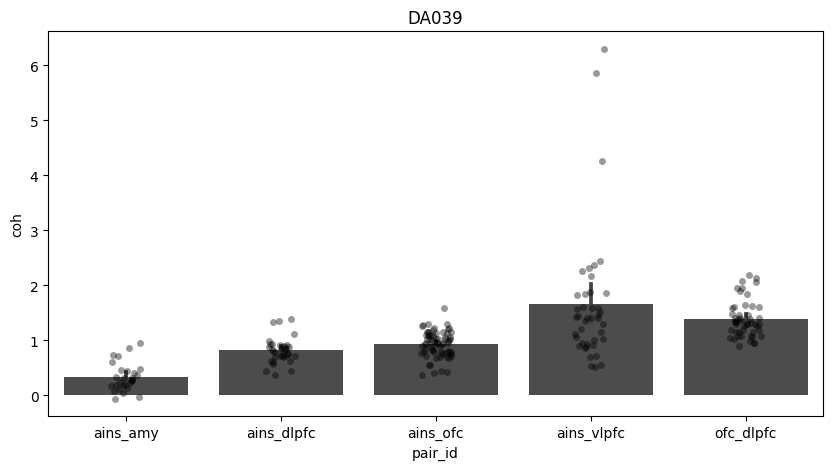

In [99]:
# add behav data to df 
pair_df_dict = {}

da39_df = all_pairs_coh_data[all_pairs_coh_data.subj_id == 'DA039'].groupby(['pair_id','unique_ch_pair']
                                                                           ).agg('mean').reset_index()

fig,ax = plt.subplots(figsize=(10,5))

sns.barplot(data=da39_df,x='pair_id',y='coh',color='k',alpha=0.7) 

sns.stripplot(data=da39_df,x='pair_id',y='coh',
                alpha=.4,
                dodge=True,color='k')
plt.title('DA039')
# for pair in da39_df.pair_id.unique().tolist():
    
# for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
#     pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
#     pair_df_dict[pair_id] = pair_df
    
#     pair_bdi_df = pair_df.groupby(['subj_id','unique_ch_pair']).agg('mean') 
    
#     fig,ax = plt.subplots(1,1,figsize=(7,5))
#     sns.regplot(data=pair_bdi_df,x='bdi',y='coh',scatter=True)
#     plt.title(pair_id)

Text(0.5, 1.0, 'MS050')

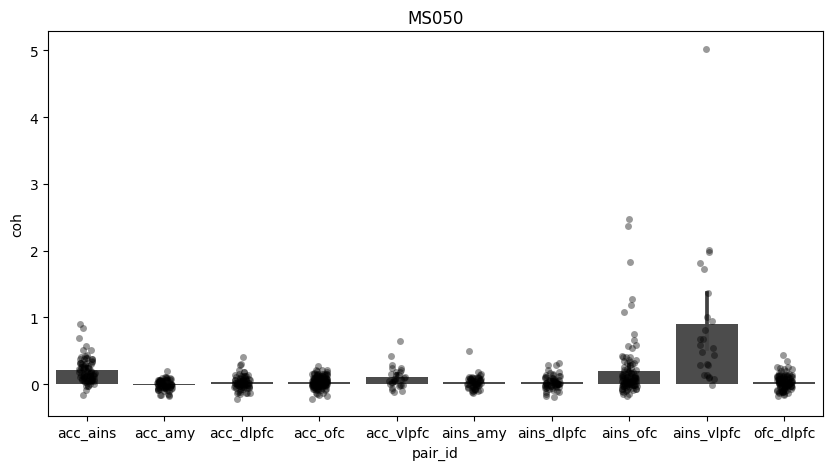

In [100]:
# add behav data to df 
pair_df_dict = {}

ms50_df = all_pairs_coh_data[all_pairs_coh_data.subj_id == 'MS050'].groupby(['pair_id','unique_ch_pair']
                                                                           ).agg('mean').reset_index()

fig,ax = plt.subplots(figsize=(10,5))

sns.barplot(data=ms50_df,x='pair_id',y='coh',color='k',alpha=0.7) 

sns.stripplot(data=ms50_df,x='pair_id',y='coh',
                alpha=.4,
                dodge=True,color='k')
plt.title('MS050')

In [ ]:
# add behav data to df 
pair_df_dict = {}

for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    pair_df_dict[pair_id] = pair_df
    
    pair_bdi_df = pair_df.groupby('subj_id','').agg('mean')
    
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    sns.scatterplot(data=pair_bdi_df,x='bdi',y='coh_norm')
    plt.title(pair_id)

In [70]:
pair_bdi_df.columns

Index(['index', 'epoch', 'coh', 'bdi', 'Round', 'coh_z', 'coh_norm', 'RT',
       'TrialOnset', 'ChoiceOnset', 'DecisionOnset', 'FeedbackOnset',
       'SafeBet', 'LowBet', 'HighBet', 'Profit', 'TotalProfit', 'logRT',
       'GambleEV', 'TrialEV', 'CR', 'choiceEV', 'rpe', 'cf', 'max_cf', 'cpe',
       'max_cpe', 'Round_t1', 'RT_t1', 'SafeBet_t1', 'LowBet_t1', 'HighBet_t1',
       'Profit_t1', 'TotalProfit_t1', 'epoch_t1', 'logRT_t1', 'GambleEV_t1',
       'TrialEV_t1', 'CR_t1', 'choiceEV_t1', 'rpe_t1', 'cf_t1', 'max_cf_t1',
       'cpe_t1', 'max_cpe_t1', 'CpeOnset'],
      dtype='object')

In [ ]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


In [105]:
# add behav data to df 


for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    # robust regression w bdi 
    pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values), M=sm.robust.norms.HuberT()).fit()
    print('pair id :', f'{pair_id} coeff = {pair_rlm.params[-1]} pval = {pair_rlm.pvalues[-1]}')



pair id : acc_ains coeff = -0.3854031190473878 pval = 6.539638227350544e-99
pair id : acc_ofc coeff = -0.08174026044602983 pval = 4.941780476096721e-12
pair id : acc_dlpfc coeff = -0.06355726400504513 pval = 2.7543675782502976e-05
pair id : acc_vlpfc coeff = -0.16882250711826785 pval = 3.4316794192134905e-36
pair id : acc_amy coeff = 0.08961024107228902 pval = 7.555870358754285e-08
pair id : ains_ofc coeff = 0.020854652267263185 pval = 0.22394949270933961
pair id : ains_dlpfc coeff = 0.27859768853233985 pval = 1.606487615382375e-26
pair id : ains_vlpfc coeff = -0.19696961054521797 pval = 3.7765126312937234e-36
pair id : ains_amy coeff = 0.0952721992447552 pval = 0.00043965511793384157
pair id : ofc_dlpfc coeff = 0.3116737004580914 pval = 4.797171877879992e-103


In [138]:
# # well fkn goddamn brightside is acc-ains, acc-ofc, acc-vlpfc, acc-amy, ains-dlpfc, ains-vlpfc, and ofc-dlpfc are all significangt 
# # add behav data to df 

# beta_coh_bdi_df = []


# for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
#     pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
#     pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values),
#                       M=sm.robust.norms.HuberT()).fit()
#     pair_coeff, pair_pval = [pair_rlm.params[-1],pair_rlm.pvalues[-1]]
#     # robust regression w bdi 
#     low_cpe_df  = pair_df[pair_df.cpe_split==0]
#     high_cpe_df = pair_df[pair_df.cpe_split==1]
    
#     lowcpe_pair_rlm = sm.RLM(low_cpe_df.bdi.values, sm.add_constant(low_cpe_df.coh.values),
#                       M=sm.robust.norms.HuberT()).fit()
#     low_cpe_coeff, low_cpe_pval = [lowcpe_pair_rlm.params[-1],lowcpe_pair_rlm.pvalues[-1]]
#     #     print('pair id :', f'{pair_id} coeff = {lowcpe_pair_rlm.params[-1]} pval = {lowcpe_pair_rlm.pvalues[-1]}')
    
#     highcpe_pair_rlm = sm.RLM(high_cpe_df.bdi.values, sm.add_constant(high_cpe_df.coh.values), 
#                               M=sm.robust.norms.HuberT()).fit()
#     high_cpe_coeff, high_cpe_pval = [highcpe_pair_rlm.params[-1],highcpe_pair_rlm.pvalues[-1]]
# #     print('pair id :', f'{pair_id} coeff = {highcpe_pair_rlm.params[-1]} pval = {highcpe_pair_rlm.pvalues[-1]}')
#     beta_coh_bdi_df.append(pd.DataFrame({'pair_id':pair_id,
#                                          'pair_coeff':pair_coeff,
#                                          'pair_pval':np.round(pair_pval,6),
#                                          'low_cpe_coeff':low_cpe_coeff,
#                                          'low_cpe_pval':np.round(low_cpe_pval,6),
#                                          'high_cpe_coeff':high_cpe_coeff,
#                                          'high_cpe_pval':np.round(high_cpe_pval,6)},index=[0]))
    
# beta_coh_bdi_df = pd.concat(beta_coh_bdi_df).reset_index(drop=True)
# beta_coh_bdi_df

In [131]:
# # add behav data to df 



# for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
#     pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
#     # robust regression w bdi 
#     low_cpe_df  = pair_df[pair_df.cpe_split==0]
#     high_cpe_df = pair_df[pair_df.cpe_split==1]
    
#     lowcpe_pair_rlm = sm.RLM(low_cpe_df.coh.values, sm.add_constant(low_cpe_df.bdi.values),
#                       M=sm.robust.norms.HuberT()).fit()
#     print('pair id :', f'{pair_id} coeff = {lowcpe_pair_rlm.params[-1]} pval = {lowcpe_pair_rlm.pvalues[-1]}')
    
#     highcpe_pair_rlm = sm.RLM(high_cpe_df.coh.values, sm.add_constant(high_cpe_df.bdi.values), 
#                               M=sm.robust.norms.HuberT()).fit()
#     print('pair id :', f'{pair_id} coeff = {highcpe_pair_rlm.params[-1]} pval = {highcpe_pair_rlm.pvalues[-1]}')


In [137]:
# # add behav data to df 


# for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
#     pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
#     # robust regression w bdi 
#     pair_rlm = sm.RLM(pair_df.coh.values, sm.add_constant(pair_df.bdi.values), M=sm.robust.norms.HuberT()).fit()
#     print('pair id :', f'{pair_id} coeff = {pair_rlm.params[-1]} pval = {pair_rlm.pvalues[-1]}')


In [10]:
# all_pairs_coh_data = []
# all_pair_subj = {}

# for pair in pairs:
    
#     source_region = pair[0]
#     target_region = pair[1]    
    
#     # unique pair id roi1_roi2
#     pair_id = '_'.join([source_region,target_region])
    
#     # find subj with elecs in each roi 
#     source_subj = roi_subj_ids[source_region]
#     target_subj = roi_subj_ids[target_region]
#     # find subj with elecs in both rois
#     pair_subj = list(set(source_subj).intersection(target_subj))    
#     # save pair subj list 
#     all_pair_subj[pair_id] = pair_subj
    
#     # initialize the storage list 
#     all_subj_pair_df = []
    
#     # iterate through pair subjects
#     for subj_id in pair_subj:
        
#         # load & format rereferenced epoch data 
#         subj_epochs = mne.read_epochs(f'{neural_dir}{subj_id}/{epoch_id}_epochs-clean.fif', preload=True)
#         subj_elecs  = subj_epochs.ch_names
        
#         # construct the seed-to-target mapping based on subject's roi coverage 
#         elec_roi_df = roi_reref_labels_master_df[roi_reref_labels_master_df.subj_id==subj_id].reset_index(drop=True)
#         # get ch names of subj elecs in roi 
#         source_ch_names  = elec_roi_df.reref_ch_names[np.where(elec_roi_df.roi == source_region)[0]].tolist()
#         target_ch_names  = elec_roi_df.reref_ch_names[np.where(elec_roi_df.roi == target_region)[0]].tolist()
#         # get idx of ch in subj_elecs list (will correspond to idx in epochs array)
#         source_elec_idx = [subj_elecs.index(elec) for elec in source_ch_names]
#         target_elec_idx = [subj_elecs.index(elec) for elec in target_ch_names]
#         # make seed to target indices using mne function 
#         seed_to_target = seed_target_indices(
#                         source_elec_idx,
#                         target_elec_idx)
        
#         # elec name for every elec pair 
#         subj_pair_ch = list(map(lambda x,y: '_'.join([x,y]), 
#                                   [subj_elecs[idx] for idx in  seed_to_target[0]], 
#                                   [subj_elecs[idx] for idx in  seed_to_target[1]]))
#         # unique elec name for every elec pair 
#         unique_ch_pair = list(map(lambda x,y: '_'.join([x,y]), [subj_id]*len(subj_pair_ch), subj_pair_ch))
        
#         # compute pwise coherence 
#         pwise = oscillation_utils.compute_connectivity(subj_epochs.copy(), 
#                                            band = freq_dict[band], 
#                                            metric = metric, 
#                                            indices = seed_to_target, 
#                                            freqs = freqs, 
#                                            n_cycles = n_cycles,
#                                            buf_ms = buf_ms, 
#                                            n_surr=n_surr,
#                                            avg_over_dim='time',
#                                            band1 = freq_dict[band],
#                                            parallelize=True)

        
#         coh_df = pd.concat([pd.DataFrame({'epoch':np.arange(0,pwise.shape[0]),'coh':pwise[:,ch_ix],
#                                           'unique_ch_pair':[ch_name]*pwise.shape[0],
#                                           'roi_pair_chans':['_'.join(ch_name.split('_')[1:])]*pwise.shape[0],
#                                           'roi1_ch_names':[ch_name.split('_')[1]]*pwise.shape[0],
#                                           'roi2_ch_names':[ch_name.split('_')[2]]*pwise.shape[0],
#                                           'roi1_elec_idx':[seed_to_target[0]]*pwise.shape[0],
#                                           'roi2_elec_idx':[seed_to_target[1]]*pwise.shape[0]}) 
#                             for ch_ix, ch_name in enumerate(unique_ch_pair)])



#         coh_df['subj_id']  = subj_id
#         coh_df['bdi']      = all_behav[all_behav.subj_id == subj_id].bdi.unique().tolist()[0]
#         coh_df['Round']    = all_behav[all_behav.subj_id == subj_id].Round.astype(int)
#         coh_df['epoch']    = all_behav[all_behav.subj_id == subj_id].epoch.astype(int)
#         coh_df['band']     = band
#         coh_df['metric']   = metric
#         coh_df['pair_id']  = pair_id
#         coh_df['roi1']     = source_region
#         coh_df['roi2']     = target_region

#         # one pair one subj data 
#         coh_df.to_csv(f'{save_dir}{subj_id}_{pair_id}_{metric}_{band}_df.csv')
#         all_subj_pair_df.append(coh_df)
#         del coh_df, subj_epochs,pwise
#         print(f'finished {subj_id} {pair_id}')
        
#     # one pair all subj data 
#     print(f'finished all {pair_id}')
#     all_subj_pair_df = pd.concat(all_subj_pair_df).reset_index()
#     # save roi pair df separately 
#     all_subj_pair_df.to_csv(f'{save_dir}{pair_id}_{metric}_{band}_df.csv', index=False)
    
#     # add all_subj_pair_df to master df 
#     all_pairs_coh_data.append(all_subj_pair_df)
    
# all_pairs_coh_data = pd.concat(all_pairs_coh_data).reset_index(drop=True)
# all_pairs_coh_data.to_csv(f'{save_dir}{metric}_{band}_{date}_df.csv', index=False)
# all_pairs_coh_data

pair id : acc_ains coeff = -0.3854031190473878 pval = 6.539638227350544e-99
pair id : acc_ofc coeff = -0.08174026044602983 pval = 4.941780476096721e-12
pair id : acc_dlpfc coeff = -0.06355726400504513 pval = 2.7543675782502976e-05
pair id : acc_vlpfc coeff = -0.16882250711826785 pval = 3.4316794192134905e-36
pair id : acc_amy coeff = 0.08961024107228902 pval = 7.555870358754285e-08
pair id : ains_ofc coeff = 0.020854652267263185 pval = 0.22394949270933961
pair id : ains_dlpfc coeff = 0.27859768853233985 pval = 1.606487615382375e-26
pair id : ains_vlpfc coeff = -0.19696961054521797 pval = 3.7765126312937234e-36
pair id : ains_amy coeff = 0.0952721992447552 pval = 0.00043965511793384157
pair id : ofc_dlpfc coeff = 0.3116737004580914 pval = 4.797171877879992e-103


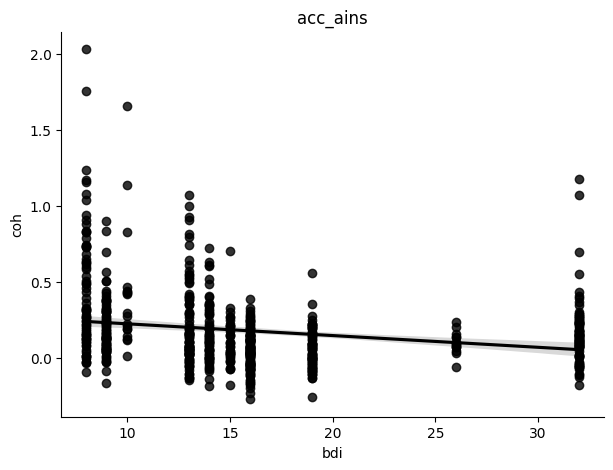

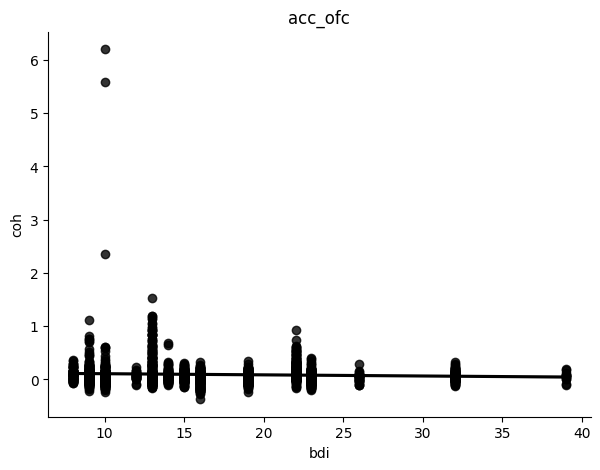

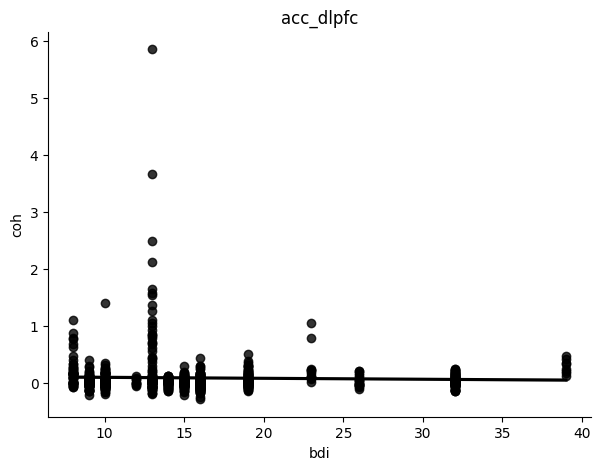

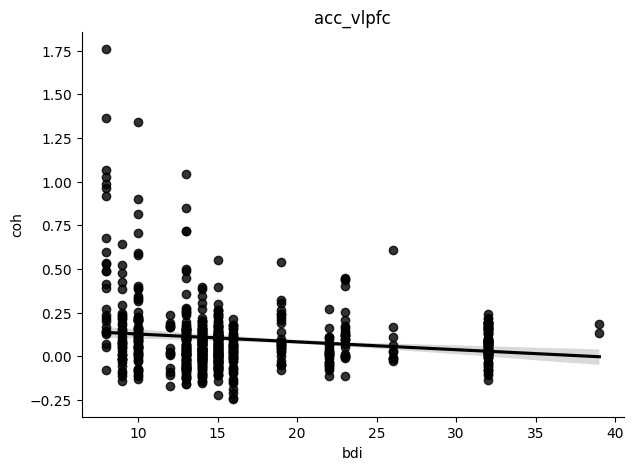

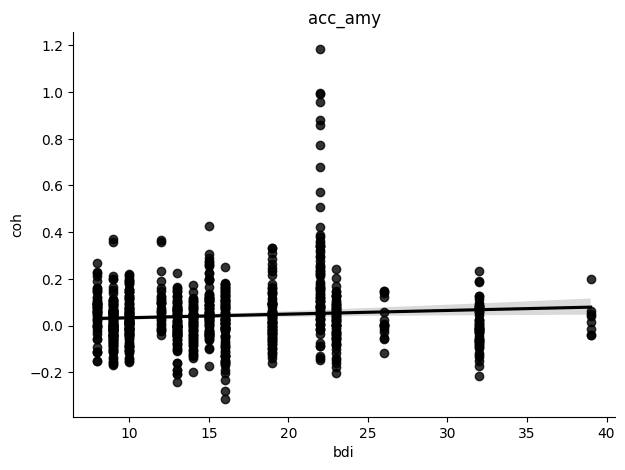

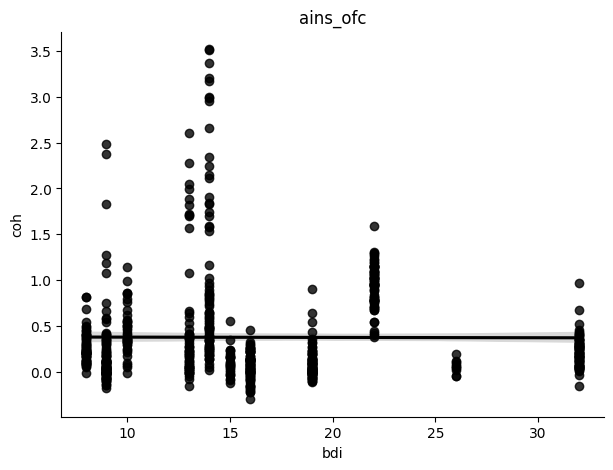

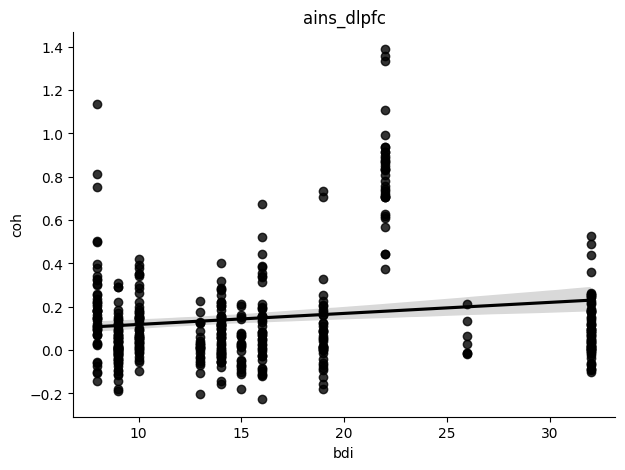

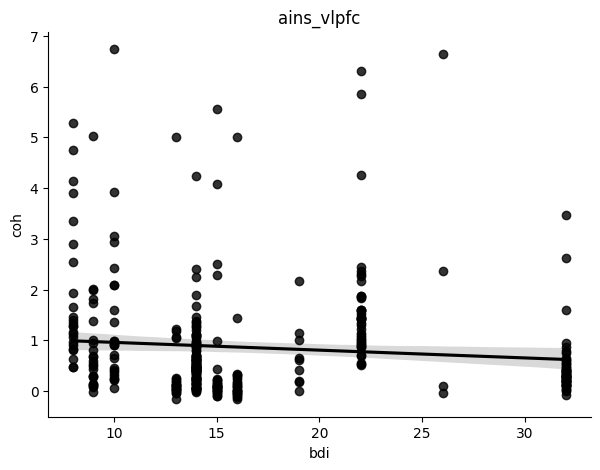

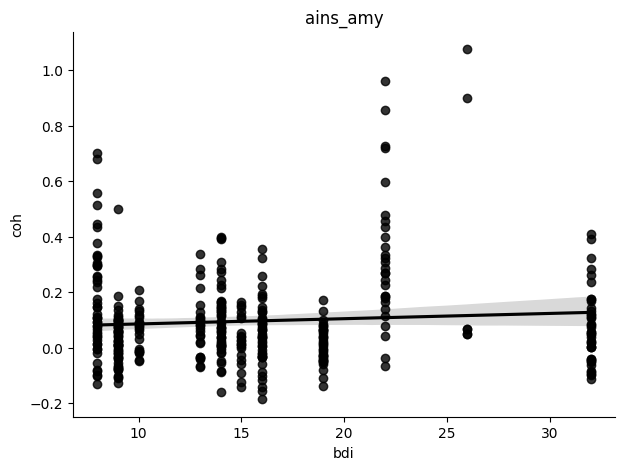

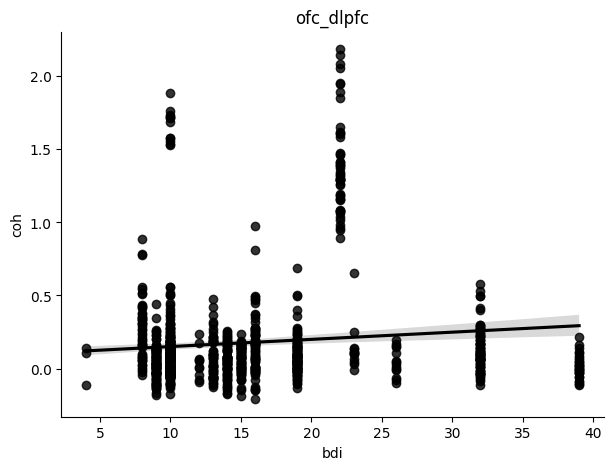

In [141]:
# add behav data to df 
pair_df_dict  = {}
pair_rlm_dict = {}

for pair_id in all_pairs_coh_data.pair_id.unique().tolist():
    pair_df = all_pairs_coh_data[all_pairs_coh_data.pair_id == pair_id]
    # robust regression w bdi 
    pair_rlm = sm.RLM(pair_df.bdi.values, sm.add_constant(pair_df.coh.values), M=sm.robust.norms.HuberT()).fit()
    print('pair id :', f'{pair_id} coeff = {pair_rlm.params[-1]} pval = {pair_rlm.pvalues[-1]}')
    # save data 
    pair_rlm_dict[pair_id] = pair_rlm
    pair_df_dict[pair_id]  = pair_df
    
    # plot subj elec means by bdi
    pair_bdi_df = pair_df.groupby(['subj_id','unique_ch_pair']).agg('mean').reset_index()
    
    fig,ax = plt.subplots(1,1,figsize=(7,5))
    sns.regplot(data=pair_bdi_df,x='bdi',y='coh',scatter=True,ci=95,color='k')
    plt.title(pair_id)
    sns.despine()